<img src="banner.png" align="left">

In [2]:
import logging
logging.basicConfig()
logging.getLogger('mkidgen3').setLevel('DEBUG')
import pynq
import time
from pynq import PL

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc

In [10]:
ol = g3.configure('./fccm22_demo/opfb_rfdc_loopback.bit', clocks=True, external_10mhz=True,
                  ignore_version=True)

INFO:mkidgen3:PL Bitfile: /home/xilinx/jupyter_notebooks/fccm22_demo/opfb_rfdc_loopback.bit (2022/5/8 3:2:22 +471920)  Loaded: True


## Setup DAC to playback a waveform with tones

Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.

In [13]:
tones = np.array([300e6, 300.5e6])
snr = 'max'

Generate the requested noise floor

In [14]:
Ns=2**19
if snr != 'max':
    a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
    in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=Ns) + 1j*np.random.uniform(-1,1,size=Ns))

In [15]:
amplitudes = np.ones_like(tones)/tones.shape[0]
dactable = generate_dac_comb(frequencies=tones, n_samples=Ns, sample_rate=4.096e9, amplitudes=amplitudes)
if snr != 'max':
    #TODO Add in the noise
    pass

In [20]:
if ol.dac_table_axim_0.register_map.run.run:
    ol.dac_table_axim_0.stop()
ol.dac_table_axim_0.replay(dactable['iq'], fpgen='simple')

## ADC Capture

In [21]:
N = Ns
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
time = np.linspace(0, Tc, N) # Time vector (seconds)

In [22]:
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**15  #Normalize to unity

DEBUG:mkidgen3.drivers.capture:Capture of ddciq not supported
DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500000000 from source adc


In [33]:
import importlib
import mkidgen3
importlib.reload(mkidgen3.plotting)

<module 'mkidgen3.plotting' from '/home/xilinx/src/mkidgen3/mkidgen3/plotting.py'>

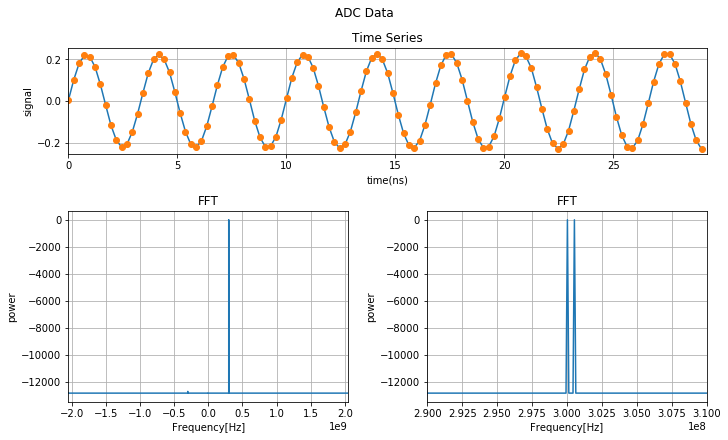

In [35]:
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096)
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom, figsize=(10, 6))

In [10]:
fft_start = 16
fft_stop = 20*4096+16
fft_sl = slice(fft_start, fft_stop)

 Calculate the FFT power spectrum and its frequencies, shifting so that 0 Hz is in the center.

In [ ]:
fft_freqs = np.linspace(-2.048e9, 2.048e9,fft_stop-fft_start)
y_fft = np.abs(fftshift(fft(adc_capture_data[fft_sl])))

## OPFB Capture

In [15]:
opfb_raw = g3.capture_opfb(1024, raw=True)
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])

In [17]:
opfb_shifted = np.roll(opfb_fp, 16, axis=1)

# Plot OPFB

In [ ]:
from mkidgen3.dsp import opfb_bin_spectrum, opfb_bin_freq

In [20]:
def plot_opfb_bins(data, bins, fine_fft_shift = True, fft_shift = True, left_snip=0, ol=True):
    """
    Inputs:
    - data: Raw data out of OPFB. Should be in the form N x 4096 where N is the number of samples from a single bin.
    - bins: list of OPFB bins 0 to 4095 (note bin 0 is far left in the +/- 2 GHz spectrum).
    - fine_fft_shift: boolean. To apply an fft shift to the fine fft spectrum of each bin or not. (You should.)
    - fft_shift: boolean. To apply an fft shift to the entire OPFB output spectrum or not. (You should.)
    - ol: To plot the bins as overlapping or discard the overlap region."""

    if fft_shift:
        data = np.fft.fftshift(data, axes=1)
    bin_freqs=opfb_bin_freq(bins, data.shape[0])
    spectra=opfb_bin_spectrum(data,bins)

    sl = slice(data.shape[0]//3, -data.shape[0]//3) if not ol else slice(0,-1)
    plt.plot(bin_freqs[sl], spectra[sl])
    return bin_freqs[sl], spectra[sl]

In [21]:
all_bins = np.linspace(0,4095,4096).astype(int).tolist()

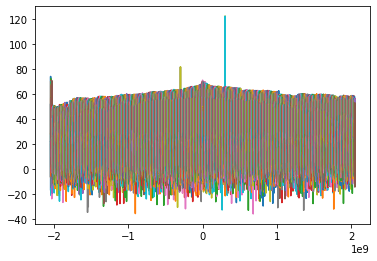

In [22]:
plt.subplot(121)
plot_opfb_bins(opfb_shifted,all_bins)
plt.subplot(122)
plot_opfb_bins(opfb_shifted,[2347,2348,2349,2350]);
